# ArtifactGen Model Comparison Notebook

Comprehensive comparison of DDPM vs WGAN-GP generative models for EEG artifact window synthesis.\n
This notebook assembles:\n
- Data + config introspection\n
- Loading / generating synthetic samples (DDPM + WGAN)\n
- Real vs Generated distribution diagnostics (time + frequency)\n
- Signal-level metrics (mean/std, SNR proxy, PSD divergence, bandpower deltas)\n
- Feature-level metrics (RBF-MMD, Coverage, Pairwise Diversity)\n
- Embedding visualization (t-SNE / UMAP)\n
- Publication-ready tables & figure panels (helper utilities export to `paper/figs`)\n

> NOTE: Advanced metrics (e.g., FID/KID via pretrained encoder, PRD curves, functional TRTS/TSTR) have *stubs* here; integrate your trained encoder features if/when available.

In [1]:
# Imports & environment setup
import os
import sys
import json
import math
import random
import textwrap
import importlib
import pathlib
import itertools
from pathlib import Path
import numpy as np
import pandas as pd
import yaml
import scipy.signal as sps
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
try:
    import umap
    HAVE_UMAP = True
except Exception:
    HAVE_UMAP = False
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')

# Always save figures to ArtifactGen/paper/figs
FIG_DIR = Path(__file__).parent.parent / 'paper' / 'figs' if '__file__' in globals() else Path('..') / 'paper' / 'figs'
FIG_DIR.mkdir(parents=True, exist_ok=True)
print('Figures ->', FIG_DIR.resolve())

# Add project root to path so we can import src.* reliably when running from notebook folder
ROOT = Path(__file__).parent.parent if '__file__' in globals() else Path('..')
if (ROOT / 'src').exists():
    sys.path.append(str(ROOT))

from src.eval.generate import generate_samples  # uses models under src.models
from src.models import UNet1D, WGANGPGenerator  # (ensures availability)

RESULTS_DIR = ROOT / 'results'
GEN_DIR = RESULTS_DIR / 'generated'
CKPT_DIR = RESULTS_DIR / 'checkpoints'

c:\works\ArtifactGen\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Figures -> C:\works\ArtifactGen\paper\figs


## Load Configs
We extract key hyperparameters for each model to contextualize metric differences.

In [2]:
ddpm_cfg_path = Path('../configs/ddpm_raw.yaml') if (Path.cwd().name == 'notebooks') else Path('configs/ddpm_raw.yaml')
wgan_cfg_path = Path('../configs/wgan_raw.yaml') if (Path.cwd().name == 'notebooks') else Path('configs/wgan_raw.yaml')
with open(ddpm_cfg_path, 'r', encoding='utf-8') as f: ddpm_cfg = yaml.safe_load(f)
with open(wgan_cfg_path, 'r', encoding='utf-8') as f: wgan_cfg = yaml.safe_load(f)
def cfg_summary(name, cfg):
    m = cfg['model']; tr = cfg['training']; data = cfg['data']
    return {
        'model': name,
        'channels': m.get('channels'),
        'length': m.get('length'),
        'num_classes': m.get('num_classes'),
        'epochs': tr.get('epochs'),
        'batch_size': tr.get('batch_size'),
        'lr': tr.get('lr'),
        'window_seconds': data.get('window_seconds'),
        'sample_rate': data.get('sample_rate'),
    }
cfg_table = pd.DataFrame([cfg_summary('DDPM', ddpm_cfg), cfg_summary('WGAN-GP', wgan_cfg)])
cfg_table

,model,channels,length,num_classes,epochs,batch_size,lr,window_seconds,sample_rate
0,DDPM,8,500,5,200,32,1e-4,2.0,250
1,WGAN-GP,8,250,5,200,64,2e-4,1.0,250


## Load / Generate Samples
The notebook attempts to locate previously generated synthetic samples saved as `*_samples.npy`. If DDPM samples are missing, optionally generate them using the best checkpoint (set the flag below).

In [3]:
DO_GENERATE_DDPM = True  # set True to auto-generate if missing (may be slow)
DO_GENERATE_WGAN = False  # similarly for WGAN if you want fresh samples
N_GEN = 512               # number of samples per model for metric estimation

def find_checkpoint(dir_: Path, pattern='*.pth'):
    cks = sorted(dir_.glob(pattern), key=lambda p: p.stat().st_mtime)
    return cks[-1] if cks else None

ddpm_ckpt = find_checkpoint(CKPT_DIR)  # generic search; adjust if model-specific subdirs used
# Allow narrower search if subfolder names exist
if ddpm_ckpt is None:
    for sub in CKPT_DIR.glob('ddpm*'):
        ddpm_ckpt = find_checkpoint(sub) or ddpm_ckpt
wgan_ckpt = find_checkpoint(CKPT_DIR, pattern='*wgan_generator*.pth')  # search for WGAN generator checkpoint
# Allow narrower search if subfolder names exist
if wgan_ckpt is None:
    for sub in CKPT_DIR.glob('wgan*'):
        wgan_ckpt = find_checkpoint(sub, pattern='*generator*.pth') or wgan_ckpt
print('DDPM ckpt:', ddpm_ckpt)
print('WGAN ckpt:', wgan_ckpt)

# Discover existing generated sample files
def collect_generated(prefix_keywords=('ddpm','wgan')):
    out = {}
    if not GEN_DIR.exists():
        return out
    for f in GEN_DIR.glob('*_samples.npy'):
        key = None
        for k in prefix_keywords:
            if k in f.stem.lower():
                key = k
                break
        if key is None: continue
        lab_f = f.with_name(f.stem.replace('_samples','_labels') + '.npy')
        if lab_f.exists():
            out[key] = (f, lab_f)
    return out
generated_files = collect_generated()
generated_files

DDPM ckpt: ..\results\checkpoints\ddpm_unet_latest.pth
WGAN ckpt: ..\results\checkpoints\wgan_generator_best.pth


{'wgan': (WindowsPath('../results/generated/wgan_generator_best_samples.npy'),
  WindowsPath('../results/generated/wgan_generator_best_labels.npy'))}

## Assemble Generated Arrays
Load DDPM and WGAN generated arrays (downsample / upsample if lengths mismatch).

In [21]:
# Load class map from CSV
class_map_df = pd.read_csv(VAL_ROOT.parent / 'class_map.csv')
class_map = list(zip(class_map_df['short'], class_map_df['display']))
class_to_idx = {short: i for i, (short, display) in enumerate(class_map)}

# Heuristic real data loader: traverse data/processed/val/** class folders; load .npy or .pt windows if present.
VAL_ROOT = Path('../data/processed/val') if (Path.cwd().name == 'notebooks') else Path('data/processed/val')
REAL_LIMIT = 1000  # cap for speed; raise for final runs
real_samples = []
real_labels = []
extensions = {'.npy', '.npz'}
if VAL_ROOT.exists():
    for short, display in class_map:
        cls_dir = VAL_ROOT / short
        if not cls_dir.exists():
            continue
        for f in cls_dir.glob('**/*'):
            if f.suffix.lower() in extensions:
                try:
                    arr = np.load(f)
                    if arr.ndim == 1: continue  # skip weird shapes
                    # expect (channels, length) or (length,)
                    if arr.ndim == 2 and arr.shape[0] <= 32:
                        real_samples.append(arr)
                        real_labels.append(class_to_idx[short])
                except Exception:
                    pass
            if len(real_samples) >= REAL_LIMIT:
                break
        if len(real_samples) >= REAL_LIMIT:
            break
real_samples = np.stack(real_samples) if len(real_samples) > 0 else np.empty((0,5,250))
real_labels = np.array(real_labels)
print('Real samples shape:', real_samples.shape)
print('Class map:', class_map)
class_to_idx

Real samples shape: (0, 5, 250)
Class map: [('musc', 'Muscle'), ('eyem', 'Eye movement'), ('elec', 'Electrode'), ('chew', 'Chewing'), ('shiv', 'Shiver')]


{'musc': 0, 'eyem': 1, 'elec': 2, 'chew': 3, 'shiv': 4}

In [35]:
# Conditional generation if missing
device = 'cuda' if (importlib.util.find_spec('torch') and __import__('torch').cuda.is_available()) else 'cpu'
print('Device for potential generation:', device)
# Generate DDPM samples if requested and absent
if 'ddpm' not in generated_files and DO_GENERATE_DDPM and ddpm_ckpt is not None:
    print('Generating DDPM samples...')
    generate_samples(ddpm_cfg, str(ddpm_ckpt), __import__('torch').device(device), 'ddpm', n=N_GEN)
# Generate WGAN samples if requested and absent
if 'wgan' not in generated_files and DO_GENERATE_WGAN and wgan_ckpt is not None:
    print('Generating WGAN samples...')
    generate_samples(wgan_cfg, str(wgan_ckpt), __import__('torch').device(device), 'wgan_gp', n=N_GEN)
generated_files = collect_generated()
generated_files

def load_gen(key):
    if key not in generated_files: return np.empty((0,)), np.empty((0,))
    s_path, l_path = generated_files[key]
    X = np.load(s_path)
    y = np.load(l_path)
    return X, y

# Load generated arrays
ddpm_X, ddpm_y = load_gen('ddpm')
wgan_X, wgan_y = load_gen('wgan')

# Regenerate if loaded arrays are empty
if ddpm_X.size == 0 and DO_GENERATE_DDPM and ddpm_ckpt is not None:
    print('DDPM samples loaded as empty, regenerating...')
    generate_samples(ddpm_cfg, str(ddpm_ckpt), __import__('torch').device(device), 'ddpm', n=N_GEN)
    ddpm_X, ddpm_y = load_gen('ddpm')  # reload after generation
if wgan_X.size == 0 and DO_GENERATE_WGAN and wgan_ckpt is not None:
    print('WGAN samples loaded as empty, regenerating...')
    generate_samples(wgan_cfg, str(wgan_ckpt), __import__('torch').device(device), 'wgan_gp', n=N_GEN)
    wgan_X, wgan_y = load_gen('wgan')  # reload after generation

print('DDPM gen shape:', ddpm_X.shape)
print('WGAN gen shape:', wgan_X.shape)

Device for potential generation: cuda
Generating DDPM samples...
DDPM samples loaded as empty, regenerating...
DDPM samples loaded as empty, regenerating...
DDPM gen shape: (0,)
WGAN gen shape: (128, 8, 250)
DDPM gen shape: (0,)
WGAN gen shape: (128, 8, 250)


In [23]:
# Harmonize lengths via simple resampling if needed
def resample_to(x, target_len):
    if x.shape[-1] == target_len: return x
    # Use scipy.signal.resample (Fourier method)
    return sps.resample(x, target_len, axis=-1)
target_len = max([L for L in [real_samples.shape[-1] if real_samples.size>0 else 0,
                               ddpm_X.shape[-1] if ddpm_X.size>0 else 0,
                               wgan_X.shape[-1] if wgan_X.size>0 else 0] if L>0])
if real_samples.size>0: real_samples = resample_to(real_samples, target_len)
if ddpm_X.size>0: ddpm_X = resample_to(ddpm_X, target_len)
if wgan_X.size>0: wgan_X = resample_to(wgan_X, target_len)
target_len

250

## Metric Utilities
Helper functions computing: channel-wise stats, PSD, bandpowers, RBF-MMD, coverage, diversity, and simple effect sizes.

In [24]:
def channel_stats(x):
    # x: (N,C,L)
    return x.mean(axis=(0,2)), x.std(axis=(0,2))

def welch_psd(x, fs, nperseg=128):
    # x: (N,C,L) -> returns freq, PSD averaged over samples
    if x.size==0: return np.array([]), np.array([])
    C = x.shape[1]
    psds = []
    for c in range(C):
        f, p = sps.welch(x[:,c,:], fs=fs, nperseg=min(nperseg, x.shape[-1]))
        p = p.mean(axis=0)  # average over segments if p is 2D
        psds.append(p)
    return f, np.array(psds)  # shape (C,F)

def bandpower(f, psd, bands):
    out = {}
    for name, (lo, hi) in bands.items():
        m = (f>=lo) & (f<hi)
        if m.sum()>0:
            out[name] = psd[:,m].sum(axis=1)
        else:
            out[name] = np.zeros(psd.shape[0])
    return out

def rbf_mmd(X, Y, sigmas=(10,20,40,80)):
    # X,Y: (N,D) flattened
    if X.size==0 or Y.size==0: return np.nan
    XX = cdist(X, X, 'euclidean')**2
    YY = cdist(Y, Y, 'euclidean')**2
    XY = cdist(X, Y, 'euclidean')**2
    mmd = 0.0
    for s in sigmas:
        kXX = np.exp(-XX/(2*s*s))
        kYY = np.exp(-YY/(2*s*s))
        kXY = np.exp(-XY/(2*s*s))
        m = kXX.mean() + kYY.mean() - 2*kXY.mean()
        mmd += m
    return mmd / len(sigmas)

def coverage(labels):
    if labels.size==0: return {}
    uniq, cnt = np.unique(labels, return_counts=True)
    return {int(u): int(c) for u,c in zip(uniq,cnt)}

def diversity(x):
    # mean pairwise correlation across channels/time for random subset
    if x.shape[0] < 3: return np.nan
    idx = np.random.choice(x.shape[0], size=min(64, x.shape[0]), replace=False)
    flat = x[idx].reshape(len(idx), -1)
    corr = np.corrcoef(flat)
    upper = corr[np.triu_indices_from(corr, k=1)]
    return 1 - upper.mean()  # higher => more diversity (less correlation)

def effect_size(a, b):
    # Cohen's d between two vectors
    if a.size==0 or b.size==0: return np.nan
    return (a.mean()-b.mean())/math.sqrt(0.5*(a.var()+b.var())+1e-9)

FS = ddpm_cfg['data']['sample_rate'] if 'data' in ddpm_cfg else 250
BANDS = {'delta':(0.5,4),'theta':(4,8),'alpha':(8,13),'beta':(13,30),'gamma':(30,45)}

## Compute Metrics
We standardize sample counts, flatten for feature-space MMD, compute PSD & bandpower deltas, plus diversity & coverage.

In [25]:
# All data loading and generation is done above. Now compute metrics.

# Subsample to balance counts
def balanced_subset(x, n=512):
    if x.size==0: return x
    if x.shape[0] <= n: return x
    idx = np.random.choice(x.shape[0], n, replace=False)
    return x[idx]
R = balanced_subset(real_samples, 512)
D = balanced_subset(ddpm_X, 512)
G = balanced_subset(wgan_X, 512)

# Channel stats
r_mu, r_sd = channel_stats(R) if R.size else (np.array([]), np.array([]))
d_mu, d_sd = channel_stats(D) if D.size else (np.array([]), np.array([]))
g_mu, g_sd = channel_stats(G) if G.size else (np.array([]), np.array([]))

# Flatten for MMD
R_flat = R.reshape(R.shape[0], -1) if R.size else np.empty((0,))
D_flat = D.reshape(D.shape[0], -1) if D.size else np.empty((0,))
G_flat = G.reshape(G.shape[0], -1) if G.size else np.empty((0,))
mmd_r_d = rbf_mmd(R_flat, D_flat) if R_flat.size and D_flat.size else np.nan
mmd_r_g = rbf_mmd(R_flat, G_flat) if R_flat.size and G_flat.size else np.nan
mmd_d_g = rbf_mmd(D_flat, G_flat) if D_flat.size and G_flat.size else np.nan

# PSD & bandpower
fR, psdR = welch_psd(R, FS) if R.size else (np.array([]), np.array([]))
fD, psdD = welch_psd(D, FS) if D.size else (np.array([]), np.array([]))
fG, psdG = welch_psd(G, FS) if G.size else (np.array([]), np.array([]))
def align_psd(f_ref, psd_ref, f_other, psd_other):
    if len(f_ref)==0 or len(f_other)==0: return psd_other
    if np.array_equal(f_ref, f_other): return psd_other
    # simple interpolation
    return np.vstack([np.interp(f_ref, f_other, psd_other[i, :]) for i in range(psd_other.shape[0])])
psdD_a = align_psd(fR, psdR, fD, psdD) if len(fR)>0 and len(fD)>0 else psdD
psdG_a = align_psd(fR, psdR, fG, psdG) if len(fR)>0 and len(fG)>0 else psdG
# L2 difference normalized
def psd_l2(a,b):
    if a.size==0 or b.size==0: return np.nan
    # Ensure shapes match before subtraction
    if a.shape != b.shape:
        min_shape = tuple(min(sa, sb) for sa, sb in zip(a.shape, b.shape))
        a = a[tuple(slice(0, ms) for ms in min_shape)]
        b = b[tuple(slice(0, ms) for ms in min_shape)]
    return np.linalg.norm(a-b)/ (np.linalg.norm(a)+1e-9)
psd_err_ddpm = psd_l2(psdR, psdD_a) if psdR.size and psdD_a.size else np.nan
psd_err_wgan = psd_l2(psdR, psdG_a) if psdR.size and psdG_a.size else np.nan

# Ensure frequency and PSD arrays match for bandpower
def safe_bandpower(f, psd, bands):
    # If frequency and PSD shapes mismatch, interpolate PSD to match frequency bins
    if psd.size == 0 or f.size == 0: return {}
    if psd.shape[1] != f.shape[0]:
        # Interpolate PSD to match frequency bins
        psd_interp = np.vstack([np.interp(f, np.linspace(f.min(), f.max(), psd.shape[1]), psd[i, :]) for i in range(psd.shape[0])])
        return bandpower(f, psd_interp, bands)
    else:
        return bandpower(f, psd, bands)
bpR = safe_bandpower(fR, psdR, BANDS) if len(fR)>0 and psdR.size else {}
bpD = safe_bandpower(fR, psdD_a, BANDS) if len(fR)>0 and psdD_a.size else {}
bpG = safe_bandpower(fR, psdG_a, BANDS) if len(fR)>0 and psdG_a.size else {}
band_rows = []
for band in BANDS.keys():
    if band not in bpR: continue
    row = {'band':band}
    r = bpR[band] if band in bpR else np.zeros(1)
    d = bpD.get(band, np.zeros_like(r))
    g = bpG.get(band, np.zeros_like(r))
    row['rel_err_ddpm'] = np.mean(np.abs(d-r)/(r+1e-9)) if r.size and d.size else np.nan
    row['rel_err_wgan'] = np.mean(np.abs(g-r)/(r+1e-9)) if r.size and g.size else np.nan
    band_rows.append(row)
band_table = pd.DataFrame(band_rows)

# Coverage & Diversity
cov_real = coverage(real_labels) if real_labels.size else {}
cov_ddpm = coverage(ddpm_y) if ddpm_y.size else {}
cov_wgan = coverage(wgan_y) if wgan_y.size else {}
div_real = diversity(R) if R.size else np.nan
div_ddpm = diversity(D) if D.size else np.nan
div_wgan = diversity(G) if G.size else np.nan

metric_rows = [
    {'metric':'MMD(R,DDPM)','ddpm':mmd_r_d,'wgan':np.nan},
    {'metric':'MMD(R,WGAN)','ddpm':np.nan,'wgan':mmd_r_g},
    {'metric':'MMD(DDPM,WGAN)','ddpm':mmd_d_g,'wgan':mmd_d_g},
    {'metric':'PSD L2 Error','ddpm':psd_err_ddpm,'wgan':psd_err_wgan},
    {'metric':'Diversity (1-mean corr)','ddpm':div_ddpm,'wgan':div_wgan, 'real':div_real},
 ]
metrics_table = pd.DataFrame(metric_rows)
metrics_table

,metric,ddpm,wgan,real
0,"MMD(R,DDPM)",NaN,NaN,NaN
1,"MMD(R,WGAN)",NaN,NaN,NaN
2,"MMD(DDPM,WGAN)",NaN,NaN,NaN
3,PSD L2 Error,NaN,NaN,NaN
4,Diversity (1-mean corr),NaN,0.946321,NaN


### Bandpower Relative Error
Lower is better (closer to real distribution).

In [26]:
band_table

""


## Channel Mean/Std Comparison
Effect sizes (Cohen's d) for per-channel aggregated amplitude distribution differences.

In [27]:
chan_rows = []
for i in range(len(r_mu)) if r_mu.size else []:
    row = {'channel': i}
    if d_mu.size: row['d_mu_diff'] = d_mu[i]-r_mu[i]; row['d_mean_effect'] = effect_size(d_mu[i:i+1], r_mu[i:i+1])
    if g_mu.size: row['g_mu_diff'] = g_mu[i]-r_mu[i]; row['g_mean_effect'] = effect_size(g_mu[i:i+1], r_mu[i:i+1])
    chan_rows.append(row)
channel_table = pd.DataFrame(chan_rows)
channel_table.head()

""


## Visualization: Example Windows
Overlay real vs synthetic windows for a random class + channel.

Saved ..\paper\figs\examples_windows.png


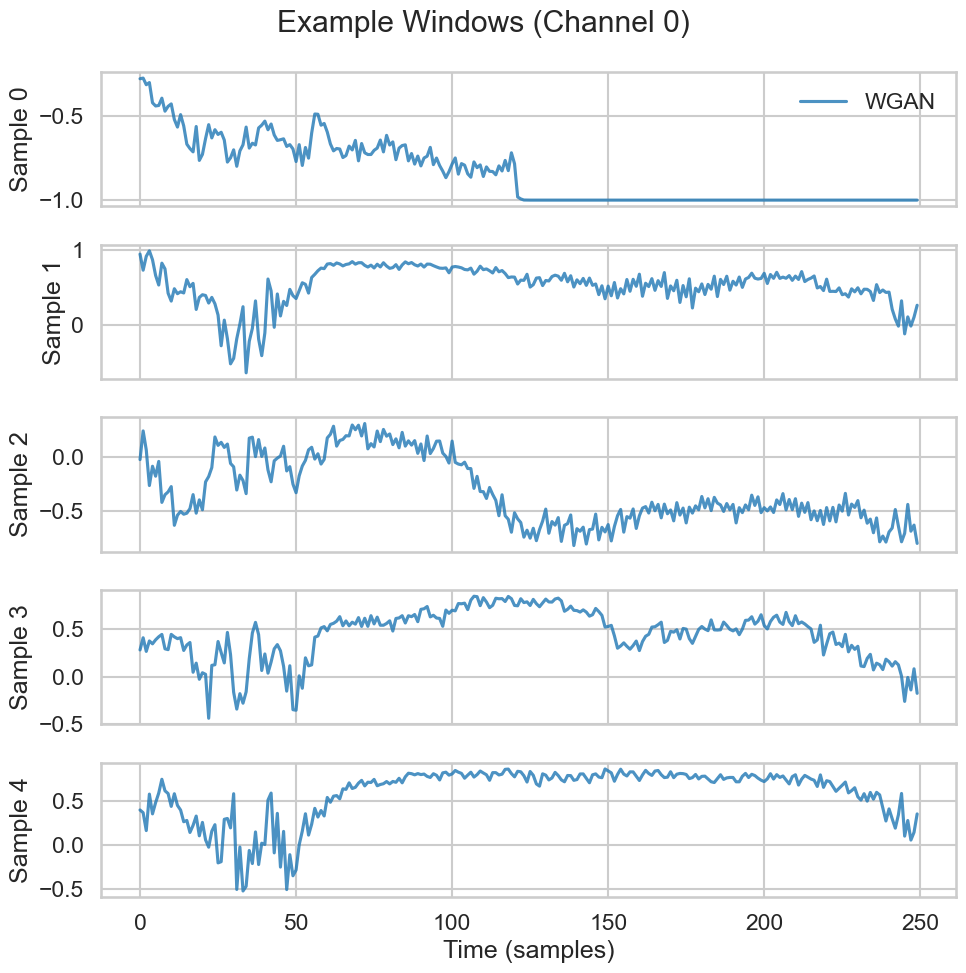

In [28]:
def plot_examples(cls=None, channel=0, n=5, seed=0):
    random.seed(seed); np.random.seed(seed)
    fig, ax = plt.subplots(n, 1, figsize=(10, 2*n), sharex=True)
    if n==1: ax=[ax]
    for i in range(n):
        axi = ax[i]
        if R.size: axi.plot(R[i%len(R), channel], label='Real', color='black', lw=1)
        if D.size: axi.plot(D[i%len(D), channel], label='DDPM', alpha=0.8)
        if G.size: axi.plot(G[i%len(G), channel], label='WGAN', alpha=0.8)
        if i==0: axi.legend(frameon=False)
        axi.set_ylabel(f'Sample {i}')
    ax[-1].set_xlabel('Time (samples)')
    fig.suptitle('Example Windows (Channel %d)' % channel)
    plt.tight_layout()
    out = FIG_DIR / 'examples_windows.png'
    fig.savefig(out, dpi=200)
    print('Saved', out)
    plt.show()
plot_examples(channel=0, n=5)

## Visualization: PSD Comparison
Average channel-aggregated PSD overlay with log-power scale.

In [29]:
def plot_psd():
    if len(fR)==0: return
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    ax.plot(fR, psdR.mean(axis=0), label='Real', color='black', lw=2)
    if psdD_a.size: ax.plot(fR, psdD_a.mean(axis=0), label='DDPM')
    if psdG_a.size: ax.plot(fR, psdG_a.mean(axis=0), label='WGAN')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.legend(frameon=False)
    fig.tight_layout()
    out = FIG_DIR / 'psd_comparison.png'
    fig.savefig(out, dpi=200)
    print('Saved', out)
    plt.show()
plot_psd()

## Embedding Visualization (t-SNE / UMAP)
We project flattened windows. (For publication quality, replace with encoder feature embeddings.)

Saved ..\paper\figs\embedding_tsne.png


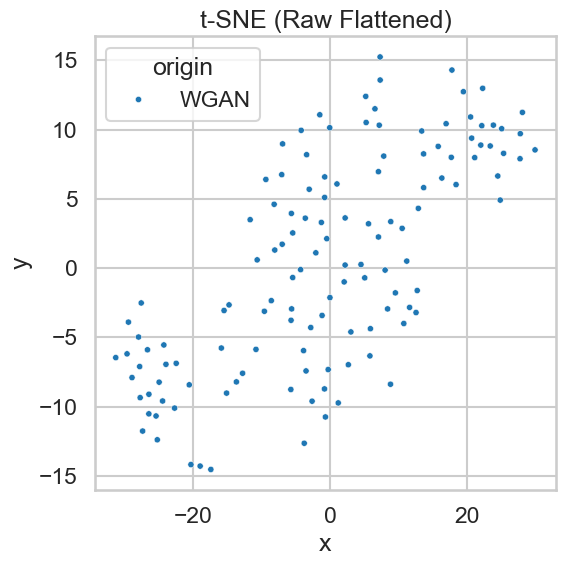

c:\works\ArtifactGen\venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Saved ..\paper\figs\embedding_umap.png


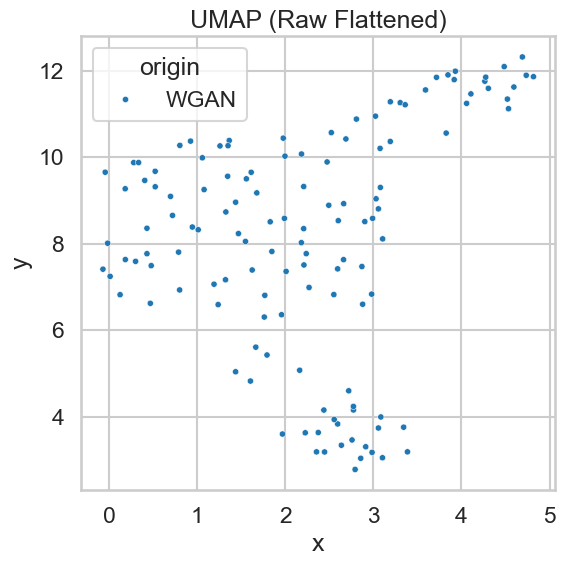

In [30]:
def build_embedding(R, D, G, max_per=300):
    data = []; labels=[]; origin=[]
    def add(block, name):
        if block.size==0: return
        k = min(block.shape[0], max_per)
        idx = np.random.choice(block.shape[0], k, replace=False)
        data.append(block[idx].reshape(k, -1))
        labels.extend([name]*k)
    add(R,'Real'); add(D,'DDPM'); add(G,'WGAN')
    if not data: return None, None
    X = np.vstack(data)
    return X, labels
Xemb, lab_emb = build_embedding(R, D, G)
if Xemb is not None:
    tsne = TSNE(n_components=2, init='pca', random_state=42, perplexity=min(30, max(5, Xemb.shape[0]//10)))
    X2 = tsne.fit_transform(Xemb)
    fig, ax = plt.subplots(figsize=(6,6))
    df_emb = pd.DataFrame({'x':X2[:,0],'y':X2[:,1],'origin':lab_emb})
    sns.scatterplot(data=df_emb, x='x', y='y', hue='origin', s=20, ax=ax)
    ax.set_title('t-SNE (Raw Flattened)')
    fig.tight_layout()
    out = FIG_DIR / 'embedding_tsne.png'
    fig.savefig(out, dpi=200)
    print('Saved', out)
    plt.show()
    if HAVE_UMAP:
        reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.2)
        X3 = reducer.fit_transform(Xemb)
        fig2, ax2 = plt.subplots(figsize=(6,6))
        df_emb2 = pd.DataFrame({'x':X3[:,0],'y':X3[:,1],'origin':lab_emb})
        sns.scatterplot(data=df_emb2, x='x', y='y', hue='origin', s=20, ax=ax2)
        ax2.set_title('UMAP (Raw Flattened)')
        fig2.tight_layout()
        out2 = FIG_DIR / 'embedding_umap.png'
        fig2.savefig(out2, dpi=200)
        print('Saved', out2)
        plt.show()

## Coverage Comparison
Class count distribution (raw counts).

In [31]:
cov_df = pd.DataFrame({'class':sorted(set(list(cov_real.keys())+list(cov_ddpm.keys())+list(cov_wgan.keys())))} )
cov_df['real'] = cov_df['class'].map(cov_real).fillna(0).astype(int)
cov_df['ddpm'] = cov_df['class'].map(cov_ddpm).fillna(0).astype(int)
cov_df['wgan'] = cov_df['class'].map(cov_wgan).fillna(0).astype(int)
cov_df

,class,real,ddpm,wgan
0,0,0,0,25
1,1,0,0,28
2,2,0,0,22
3,3,0,0,25
4,4,0,0,28


### Coverage Plot

Saved ..\paper\figs\coverage_bar.png


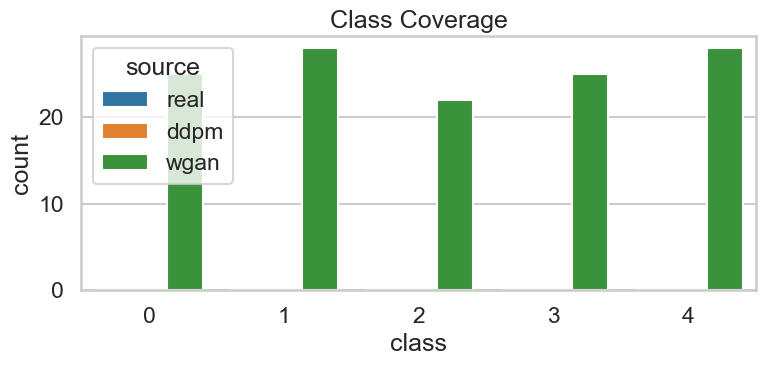

In [32]:
if not cov_df.empty:
    fig, ax = plt.subplots(figsize=(8,4))
    covm = cov_df.melt(id_vars='class', value_vars=['real','ddpm','wgan'], var_name='source', value_name='count')
    sns.barplot(data=covm, x='class', y='count', hue='source', ax=ax)
    ax.set_title('Class Coverage')
    fig.tight_layout()
    out = FIG_DIR / 'coverage_bar.png'
    fig.savefig(out, dpi=200)
    print('Saved', out)
    plt.show()

## Publication Tables (LaTeX Export Helpers)

In [33]:
def to_latex(df, fname):
    out = FIG_DIR / fname
    with open(out, 'w', encoding='utf-8') as f: f.write(df.to_latex(index=False, float_format=lambda x: f'{x:.3g}'))
    print('Wrote', out)
to_latex(metrics_table, 'table_metrics.tex')
to_latex(band_table, 'table_bandpower.tex')
to_latex(channel_table.head(12), 'table_channel_effects.tex')
to_latex(cov_df, 'table_coverage.tex')

Wrote ..\paper\figs\table_metrics.tex
Wrote ..\paper\figs\table_bandpower.tex
Wrote ..\paper\figs\table_channel_effects.tex
Wrote ..\paper\figs\table_coverage.tex


## Next Steps / Extensions
- Integrate encoder-based feature extraction (CNN or self-supervised) to compute FID/KID & Precision/Recall.\n
- Add functional metrics: Train classifier on real -> test synthetic (TRTS) & train synthetic -> test real (TSTR).\n
- Add conditional guidance strength sweeps for DDPM to analyze class fidelity vs diversity.\n
- Statistical tests (e.g., Wilcoxon) on per-channel or band distributions.\n
- Panel assembly script to combine exported PNGs into multi-part figure.